# Tutorial and Sample Code for Balancing a Pole on a Cart

In [1]:
!python -V

Python 3.8.10


## Installing dependencies:

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym\[classic_control\]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install mpi4py
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
from gym.utils.step_api_compatibility import step_api_compatibility
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import pickle
from collections import deque
from IPython.display import HTML
from IPython import display as ipythondisplay
from tqdm import tqdm
from mpi4py import MPI

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.



In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00308711  0.00858368 -0.01180391  0.02440116]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.00291544 -0.18636702 -0.01131589  0.31333658]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0


## Q-Learning

***Referenced from [1] https://qiita.com/sugulu_Ogawa_ISID/items/bc7c70e6658f204f85f9 \\
(caution: language..Japanese)

Q-learning policy is the following:
$$
Q^{new} (s, a) \leftarrow 
(1-\alpha) \cdot 
\underbrace{Q(s, a)}_{old \, value} + 
\underbrace{\alpha}_{learning \, rate} \cdot 
\overbrace{
\left(
\underbrace{r}_{reward} +
\underbrace{\gamma}_{discount \, factor} \cdot
\underbrace{\max_{a^{\prime}}Q(s^{\prime}, a^{\prime})}_{estimate \, of \, optimal \, future \, value}
\right)
}^{learned \, value}
$$

This methods create a q-table which records state and action in every espisode, and update them.

The update is followed by the learning rate - $\alpha$, the reward - r and the discount factor - $\gamma$.
Once the RL agent estimates an optimal future value, it calculates the difference from the old value and multiply $\gamma$ to 'discount' it. After that, the reward is added to the calculated value to obtain the learned value and the agent multiplies it by $\alpha$. Finally, the agent adds the calculated value to the old value and updates the q-table.

### Task 1: Development of an RL agent

Implementation of Q-Learning:

In [10]:
# ***Cited/Referenced from [1]***
class Q_Learning:
    def __init__(self, gamma, alpha, env, max_number_of_steps, num_consecutive_iter, 
                 num_episodes, goal_average_reward, num_dizitised):
        self.gamma = gamma
        self.alpha = alpha
        self.env = env
        self.max_number_of_steps = max_number_of_steps # the number of steps
        self.num_consecutive_iter = num_consecutive_iter # the number of iterations
        self.num_episodes = num_episodes # the number of episodes to learn
        self.goal_average_reward = goal_average_reward # the reward value considered to be the goal
        self.num_dizitised = num_dizitised
        
        self.q_table = np.random.uniform(low=-1,
                           high=1,
                           size=(self.num_dizitised**4, self.env.action_space.n))
        
        # Cumulative Average reward per an Episode
        self.episode_results = np.zeros(self.num_episodes)
    
    # Utility Functions
    def bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    # observation -> transform to descrete digitised state
    def digitise_state(self, observation):
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitised = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, self.num_dizitised)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, self.num_dizitised)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, self.num_dizitised)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, self.num_dizitised))
        ]
        return sum([x * self.num_dizitised**i for i, x in enumerate(digitised)])

    # Function to obtain an action a(t)
    def get_action(self, next_state, episode):
        #epsilon-greedy
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            next_action = np.argmax(self.q_table[next_state])
        else:
            next_action = np.random.choice([0, 1])
        return next_action

    # Function that updates Q-table
    def update_Qtable(self, q_table, state, action, reward, next_state):
        Q_max_next = max(self.q_table[next_state][0], self.q_table[next_state][1])
        self.q_table[state, action] = (1 - self.alpha) * self.q_table[state, action] + \
            self.alpha * (reward + self.gamma * Q_max_next)

        return self.q_table
    
    def main(self, num_episodes, out_single, video_take):
        if self.num_episodes != num_episodes:
            self.num_episodes = num_episodes
            self.episode_results = np.zeros(self.num_episodes)
        if video_take:
            self.env = RecordVideo(gym.make("CartPole-v1"), "./video")
        for episode in range(self.num_episodes): # Episodes -- 500
            # Initialisation
            observation = self.env.reset()
            state = self.digitise_state(observation)
            action = np.argmax(self.q_table[state])
            episode_reward = 0
            
            total_reward_vec = np.zeros(self.num_consecutive_iter)
            final_x = np.zeros((self.num_episodes, 1))
            islearned = 0
        
            for t in range(self.max_number_of_steps): # Steps -- 500
                if video_take:
                    self.env.render()
                observation, reward, done, info = self.env.step(action)

                if done:
                    if t < 195:
                        reward = -1
                    else:
                        reward = 1
                else:
                    reward = 0

                episode_reward += 1

                # calculate next state
                next_state = self.digitise_state(observation)
                # update Q-table
                self.q_table = self.update_Qtable(self.q_table, state, action, reward, next_state)

                # calculate next action
                action = self.get_action(next_state, episode)
                
                # for returning a single action
                if out_single:
                    return observation, action

                state = next_state

                # end of one step
                if done:
                    total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward))

                    # If the learning is finished, store the final x coordinate
                    if islearned == 1:
                        final_x[episode, 0] = observation
                    break

            # close the video environment
            if video_take:
                self.env.close()
                show_video()
                return
            self.episode_results[episode] = episode_reward
            if(total_reward_vec.mean() >= self.goal_average_reward):
                islearned = 1

One step:

In [11]:
q_learning_agent = Q_Learning(gamma=0.99, alpha=0.6, env=gym.make('CartPole-v1'), max_number_of_steps=500, num_consecutive_iter=100, 
                 num_episodes=100, goal_average_reward=195, num_dizitised=6)
observation, action = q_learning_agent.main(num_episodes=100, out_single=True, video_take=False)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.04635842  0.16482827 -0.03428421 -0.32167363]
Chosen action: 0


#### Optimising learning rate

alpha:  0.1
alpha:  0.2
alpha:  0.3
alpha:  0.4
alpha:  0.5
alpha:  0.6
alpha:  0.7
alpha:  0.8
alpha:  0.9
alpha:  1.0
The most efficient alpha:  0.7
Its average cumulative reward:  106.21


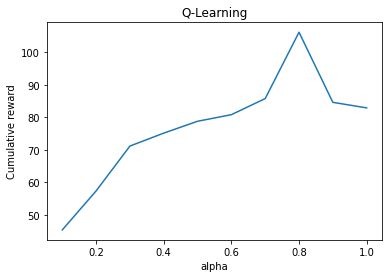

In [12]:
# Increment alpha per 0.1; iterate each alpha 10 times and measure the mean of episodes' results. 

ITER = 10
q_avr_learning_episode_results = np.zeros(10)

for alp in range(1, 11): # allocate alp / 10 as the alpha value
  q_learning_rewards = 0 
  print("alpha: ", alp / 10)
  for i in range(ITER):
    q_learning_agent = Q_Learning(gamma=0.99, alpha=alp/10, env=gym.make('CartPole-v1'), max_number_of_steps=500, num_consecutive_iter=100, 
                  num_episodes=100, goal_average_reward=195, num_dizitised=6)
    q_learning_agent.main(num_episodes=100, out_single=False, video_take=False)      
    
    q_learning_rewards += q_learning_agent.episode_results.mean()

  q_avr_learning_episode_results[alp-1] = q_learning_rewards / ITER

# print the most efficient alpha
print("The most efficient alpha: ", np.argmax(q_avr_learning_episode_results + 1) / 10)
print("Its average cumulative reward: ", np.max(q_avr_learning_episode_results))

# plot
plt.plot([i/10 for i in range(1, 11)], q_avr_learning_episode_results)
plt.title('Q-Learning')
plt.ylabel('Cumulative reward')
plt.xlabel('alpha')
plt.show()

Thus, suppose alpha is efficient in an interval of [0.6, 0.8]. \\
*** The result can vary per each running case; I just opt the interval from my multiple running.

*** Same as above, just referenced from some cases for the second decimal point,
and set alpha=0.78.


Hyperparameters:
- $\alpha$ ... learning rate (0.78)
- $\gamma$ ... discount factor (0.99)

### Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [13]:
# Launch Q-Learning

# Create a new instance
q_learning_agent = Q_Learning(gamma=0.99, alpha=0.78, env=gym.make('CartPole-v1'), max_number_of_steps=500, num_consecutive_iter=100, 
                 num_episodes = 100, goal_average_reward=195, num_dizitised=6)                            

In [14]:
# Main Routine
q_learning_agent.main(num_episodes = 100, out_single=False, video_take=False)  

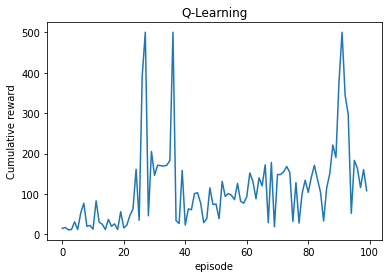

Average cumulative reward: 113.76
Is my agent good enough? False


In [15]:
plt.plot(q_learning_agent.episode_results)
plt.title('Q-Learning')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", q_learning_agent.episode_results.mean())
print("Is my agent good enough?", q_learning_agent.episode_results.mean() > 195)

### Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [16]:
q_learning_agent.main(num_episodes=1, out_single=False, video_take=True)

As the method is not good enough, take a look at another method.

(Bonus, 1000 episodes)

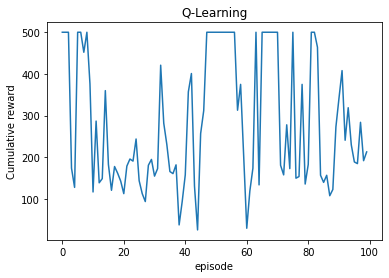

Average cumulative reward: 283.25
Is my agent good enough? True


In [17]:
q_learning_agent = Q_Learning(gamma=0.99, alpha=0.78, env=gym.make('CartPole-v1'), max_number_of_steps=500, num_consecutive_iter=100, 
                 num_episodes = 1000, goal_average_reward=195, num_dizitised=6)  
q_learning_agent.main(num_episodes = 1000, out_single=False, video_take=False)  

l = len(q_learning_agent.episode_results)
plt.plot(q_learning_agent.episode_results[l-100:l])
plt.title('Q-Learning')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", q_learning_agent.episode_results[l-100:l].mean())
print("Is my agent good enough?", q_learning_agent.episode_results[l-100:l].mean() > 195)

## Proximal Policy Optimization (PPO)

***Referenced from \\
[2] https://github.com/morikatron/PPO/tree/master/algo \\
[3] arXiv.1707.06347

$$
L^{CLIP} (\theta) = 
\hat{\mathbb{E}}_{t}
\left[
min
\left(
r_{t}(\theta)\hat{A}_{t},\,
clip(
r_{t}(\theta), \,
1 - \epsilon, \,
1 + \epsilon
) \hat{A}_{t}
\right)
\right]\\
$$

where,<br>
- $\theta$: policy parameter <br>
- $\hat{\mathbb{E}}_{t}$: the empirical expectation over timesteps<br>
- $r_{t}:$ the ratio of the probability under the new and old policies<br>
- $\hat{A}_{t}:$ the estimated advantage at time t<br>
- $\epsilon :$ hyperparameter to determinte the clipping range of L<br>

Policy:
$$
r_{t} (\theta) = 
\frac
{
\pi_{\theta} \left(
{a_{t}|s_{t}}
\right)
}
{
\pi_{{\theta}_{old}} \left(
{a_{t}|s_{t}}
\right)
},\\
\hat{A}_{t} \left( s_{t} , a_{t} \right) = 
Q \left( s_{t} , a_{t} \right) - 
V \left( s_{t} \right).
$$

Normaly, $0.1 \leq \epsilon \leq 0.3$ is chosen.
The smaller an $\epsilon$ is, the stricter the constrain is enforced.

State Value:

Objective function of the state value is:
$$
L^{VF}_{t}(\theta) = \left( V^{\theta}_{t}(s) - V^{targ}_{t}(s)\right) ^{2},\\
V^{targ}_{t}(s) = \sum_{i=0}^{\infty} \gamma^{i} r_{t+i}.
$$

Entropy:
$$
L^{s}_{t} (\theta) = - \Sigma_{a_{t}} \pi (s_{t}, a_{t})\, log(\pi(s_{t}, a_{t})).
$$<br>
Adding the entropy term $L^{s}_{t}(\theta)$ to the loss function to control the trade-off of the searching and exploitation. <br>
The smaller the entropy term is, the lesser the bias in choosing every action. <br> <br>

Generalized Advantage Estimator (GAE):
$$
A^{GAE}(s_{t}, a_{t}) = \sum_{i=0}^{\infty} (\gamma \lambda)^{i} \delta_{t+i},\\
\delta_{t} = r_{t} + \gamma V(s_{t+1}) - V(s_{t}),\\
0 \leq \lambda \leq 1.
$$<br>
GAE controls variance of the estimation and bias, which aides the stable convergence of learning.<br>
If $\lambda$ is near to 0, bias becomes learger; if near to 1, variance becomes larger.
The $\lambda$ should be smaller than the $\gamma$.

### Task 1

Implementation:

*** As I do not update the model directly, keras matrix is not made, which does not allow me to save the entire model. \\
Therefore, I just saved the trained weights and zipped this .ipynb file with the weights checkpoint (h5).

In [18]:
# ***Cited/Referenced from [2]***
# https://github.com/morikatron/PPO/blob/master/algo/util.py

# Utility
def set_global_seeds(i):
    rank = MPI.COMM_WORLD.Get_rank()
        
    myseed = i + 1000 * rank if i is not None else None
    tf.random.set_seed(myseed)
    np.random.seed(myseed)
    random.seed(myseed)

In [19]:
# ***Referenced from [2]***
# https://github.com/morikatron/PPO/blob/master/algo/config.py

# Configurations for variables
class Config():
    # learning config
    env_name = "CartPole-v1"
    seed = 1234 # seed value for tf numpy random
    num_update = 100 # the number of iteration in learning
    log_step = 100 # the frequency of displaying logs
    
    #hyperparameters
    batch_size = 32
    num_epoch = 4 
    num_step = 500 # the total number of samples stored in an iteration
    num_unit = 64 # the number of units in fc-layer
    gamma = 0.99 # discount rate
    lambda_ = 0.95 # GAE discount rate
    clip = 0.2 # clipped range
    vf_coef = 0.5 # coefficient of value loss
    ent_coef = 0.01 # coefficient of an entropy term
    learning_rate = 0.0001 # [5e-6 - 0.003]
    gradient_clip = 0.5 # the range of clipping grad

In [20]:
# ***Cited/Referenced from [2]***
# https://github.com/morikatron/PPO/blob/master/algo/ppo.py

# PPO state transition and training
EPS = 1e-8
class PPO(tf.Module):
    def __init__(self, num_actions, input_shape, config):
        super(PPO, self).__init__(name='ppo_model')
        self.num_actions = num_actions
        self.input_shape = input_shape
        self.batch_size = config.batch_size
        self.config = config
        
        self.policy_value_network = self._build_model()
        self.optimizer = Adam(learning_rate=config.learning_rate)
        self.gradient_clip = config.gradient_clip
        
    @tf.function
    def step(self, obs):
        pi, v = self.policy_value_network(obs)
        pi = tf.squeeze(pi)
        return pi, v
    
    @tf.function
    def train(self, obs, action, pi_old, advantage, rew_sum):
        with tf.GradientTape() as tape:
            policy, value = self.policy_value_network(obs)
            value = tf.squeeze(value)
            one_hot_action = tf.one_hot(action, self.num_actions)
            pi = tf.squeeze(tf.reduce_sum(policy * one_hot_action, axis=1, keepdims=True))
            ratio = tf.divide(pi, pi_old + EPS)
            clipped_advantage = tf.where(advantage>0, (1+self.config.clip) * advantage,\
                                       (1-self.config.clip) * advantage)
            l_clip = (-1) * tf.reduce_mean(tf.minimum(ratio * advantage, clipped_advantage))
            l_vf = tf.reduce_mean(tf.square(rew_sum - value))
            entropy = -tf.reduce_sum(policy * tf.math.log(policy + EPS), axis=1)
            l_ent = tf.reduce_mean(entropy)
            loss = l_clip + l_vf * self.config.vf_coef - l_ent * self.config.ent_coef
        grads = tape.gradient(loss, self.policy_value_network.trainable_variables)
        if self.gradient_clip is not None:
            clipped_grads = []
            for grad in grads:
                clipped_grads.append(tf.clip_by_norm(grad, self.gradient_clip))
            grads = clipped_grads
        grads_and_vars = zip(grads, self.policy_value_network.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars)
        
        new_policy, _ = self.policy_value_network(tf.convert_to_tensor(obs, dtype=tf.float32))
        new_prob = tf.reduce_sum(new_policy * one_hot_action, axis=1)
        kl = tf.reduce_mean(pi * tf.math.log(new_prob + EPS) - pi * tf.math.log(pi + EPS))
        clipfrac = tf.reduce_mean(tf.cast(tf.greater(tf.abs(ratio - 1.0), self.config.clip), tf.float32))
        
        return loss, l_clip, l_vf, l_ent, policy, kl, clipfrac
    
    def _build_model(self):
        input_x = tf.keras.Input(shape=self.input_shape)
        h1 = tf.keras.layers.Dense(units=self.config.num_unit, activation="relu")(input_x)
        h2 = tf.keras.layers.Dense(units=self.config.num_unit, activation="relu")(h1)
        
        policy = tf.keras.layers.Dense(self.num_actions, activation="softmax")(h2)
        value = tf.keras.layers.Dense(1)(h2)
        model = tf.keras.Model(inputs=input_x, outputs=[policy, value])
        
        return model

In [21]:
# ***Cited/Referenced from [2], [4]***
# https://github.com/morikatron/PPO/blob/master/algo/run.py

# run
class CartPoleWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CartPoleWrapper, self).__init__(env)
        self.steps = 0
        self.max_step = 500
        
    def reset(self):
        obs = self.env.reset()
        self.steps = 0
        return obs
    
    def step(self, ac):
        self.steps += 1
        obs, rew, done, info = self.env.step(ac)
        if self.steps == 500:
            done = 1
        if done:
            if self.steps > 195:
                rew = 1
            else:
                rew = -1
        else:
            rew = 0
            
        return obs, rew, done, info

# for video record
class CartPoleWrapperVid(RecordVideo):
    def __init__(self, env, 
                 video_folder,
                 episode_trigger = None,
                 step_trigger = None,
                 video_length = 0,
                 name_prefix = "rl-video",
                 new_step_api = False):
        super(CartPoleWrapperVid, self).__init__(env, video_folder,
                 episode_trigger,
                 step_trigger,
                 video_length,
                 name_prefix,
                 new_step_api)
    
    def step(self, action):
        (
            observations,
            rewards,
            terminateds,
            truncateds,
            infos,
        ) = step_api_compatibility(self.env.step(action), True, self.is_vector_env)

        if not (self.terminated or self.truncated):
            # increment steps and episodes
            self.step_id += 1
            if self.step_id == 500:
                dones = 1
            if not self.is_vector_env:
                if terminateds or truncateds:
                    self.episode_id += 1
                    self.terminated = terminateds
                    self.truncated = truncateds
            elif terminateds[0] or truncateds[0]:
                self.episode_id += 1
                self.terminated = terminateds[0]
                self.truncated = truncateds[0]

            if self.recording:
                assert self.video_recorder is not None
                self.video_recorder.capture_frame()
                self.recorded_frames += 1
                if self.video_length > 0:
                    if self.recorded_frames > self.video_length:
                        self.close_video_recorder()
                else:
                    if not self.is_vector_env:
                        if terminateds or truncateds:
                            self.close_video_recorder()
                    elif terminateds[0] or truncateds[0]:
                        self.close_video_recorder()

            elif self._video_enabled():
                self.start_video_recorder()

        return step_api_compatibility(
            (observations, rewards, terminateds, truncateds, infos),
            self.new_step_api,
            self.is_vector_env,
        )

# Memory of gathered sample for learning
class Memory:
    def __init__(self, obs_shape, hparams):
        self._hparams = hparams
        self.size = self._hparams.num_step
        self.obses = np.zeros((self.size, ) + obs_shape)
        self.actions = np.zeros((self.size, ))
        self.rewards = np.zeros((self.size, 1))
        self.dones = np.zeros((self.size, 1))
        self.values = np.zeros((self.size + 1, 1))
        self.policy = np.zeros((self.size, 1))
        self.deltas = np.zeros((self.size, 1))
        self.discounted_rew_sum = np.zeros((self.size, 1))
        self.gae = np.zeros((self.size + 1, 1))
        self.sample_i = 0
        
    def __len__(self):
        return self.size
    
    def add(self, obs, action, reward, done, value, policy):
        if self.sample_i < len(self.obses):
            self.obses[self.sample_i] = obs
            self.actions[self.sample_i] = action
            self.rewards[self.sample_i] = reward
            self.dones[self.sample_i] = done
            self.values[self.sample_i] = value
            self.policy[self.sample_i] = policy
            
        if self.sample_i > 0:
            self.deltas[self.sample_i - 1] = self.rewards[self.sample_i - 1] + \
            self._hparams.gamma * value * (1 - self.dones[self.sample_i - 1]) - \
            self.values[self.sample_i - 1]
        self.sample_i += 1
        
    def compute_gae(self):
        self.gae[-1] = self.deltas[-1]
        for t in reversed(range(self.size-1)):
            self.gae[t] = self.deltas[t] + (1 - self.dones[t]) * \
            (self._hparams.gamma * self._hparams.lambda_) * self.gae[t + 1]
        self.discounted_rew_sum = self.gae[:-1] + self.values[:-1]
        self.gae = (self.gae - np.mean(self.gae[:-1])) / (np.std(self.gae[:-1]) + 1e-8)
        return
    
    def sample(self, idxes):
        batch_obs = tf.convert_to_tensor(self.obses[idxes], dtype=tf.float32)
        batch_act = tf.convert_to_tensor(self.actions[idxes], dtype=tf.int32)
        batch_adv = tf.squeeze(tf.convert_to_tensor(self.gae[idxes], dtype=tf.float32))
        batch_pi = tf.squeeze(tf.convert_to_tensor(self.policy[idxes], dtype=tf.float32))
        batch_sum = tf.squeeze(tf.convert_to_tensor(self.discounted_rew_sum[idxes], dtype=tf.float32))
        return batch_obs, batch_act, batch_adv, batch_sum, batch_pi
    
    def reset(self):
        self.sample_i = 0
        self.obses = np.zeros_like(self.obses)
        self.actions = np.zeros_like(self.actions)
        self.rewards = np.zeros_like(self.rewards)
        self.values = np.zeros_like(self.values)
        self.policy = np.zeros_like(self.policy)
        self.deltas = np.zeros_like(self.deltas)
        self.discounted_rew_sum = np.zeros_like(self.discounted_rew_sum)
        self.gae = np.zeros_like(self.gae)

# PPO Agent
class PPO_Agent:
    def __init__(self):
        self.config = Config()
        set_global_seeds(self.config.seed)
        self.env = gym.make(self.config.env_name)
        self.env = CartPoleWrapper(self.env)
        self.episode_rewards = deque([0] * 100, maxlen=100)
        with tf.device("/gpu:0"):
            self.ppo = PPO(
                num_actions=self.env.action_space.n,
                input_shape=self.env.observation_space.shape,
                config=self.config)
            
    def main(self, out_single, video_take, save_model, load_model, skip_train):
        # for Task 3
        if load_model:
            self.ppo.policy_value_network.load_weights('./checkpoints/my_checkpoint')

        if video_take:
            self.env = CartPoleWrapperVid(gym.make("CartPole-v1"), "./video")
            
        num_episodes = 0
        memory = Memory(self.env.observation_space.shape, self.config)
        reward_sum = 0
        obs = self.env.reset()
        for t in tqdm(range(self.config.num_update)):
            for _ in range(self.config.num_step):
                policy, value = self.ppo.step(obs[np.newaxis, :])
                policy = policy.numpy()
                action = np.random.choice(2, p=policy)

                # for returning a single action
                if out_single:
                    return self.env.step(action), action
                
                next_obs, reward, done, _ = self.env.step(action)
                memory.add(obs, action, reward, done, value, policy[action])
                obs = next_obs
                reward_sum += reward
                if done:
                    if video_take:
                        obs = self.env.reset()
                        self.env.close()
                        show_video()
                        return
                    self.episode_rewards.append(self.env.steps)
                    num_episodes += 1
                    reward_sum = 0
                    obs = self.env.reset()
            _, last_value = self.ppo.step(obs[np.newaxis, :])
            # train
            if not skip_train:
              memory.add(None, None, None, None, last_value, None)
              memory.compute_gae()
              for _ in range(self.config.num_epoch):
                  idxes = [idx for idx in range(self.config.num_step)]
                  random.shuffle(idxes)
                  for start in range(0, len(memory), self.config.batch_size):
                      minibatch_idxes = idxes[start:start+self.config.batch_size]
                      batch_obs, batch_act, batch_adv, batch_sum, batch_pi_old = memory.sample(minibatch_idxes)
                      loss, policy_loss, value_loss, entropy_loss, policy, kl, frac = \
                          self.ppo.train(batch_obs, batch_act, batch_pi_old, batch_adv, batch_sum)

            memory.reset()

        # Save the trained Model as HDF5    
        if save_model:
            self.ppo.policy_value_network.save_weights('./checkpoints/my_checkpoint')
            


In [22]:
ppo_agent = PPO_Agent()
observation, action = ppo_agent.main(out_single=True, video_take=False, save_model=False, load_model=False, skip_train=False)
print("\nObservation:", observation[0])
print("Chosen action:", action)

  0%|          | 0/100 [00:00<?, ?it/s]


Observation: [-0.04676324 -0.15008056 -0.01582545  0.30573636]
Chosen action: 0


Hyperparameters:
- batch_size.. (32)
- num_epoch.. (4)
- num_step.. the total number of samples stored in an iteration (500) 
- num_unit.. the number of units in fc-layer (64) 
- gamma.. discount rate (0.99)
- lambda_.. GAE discount rate (0.95)
- clip.. clipped range (0.2)
- vf_coef.. coefficient of value loss (0.5)
- ent_coef.. coefficient of an entropy term (0.01)
- learning_rate ..(0.0001)
- gradient_clip.. the range of clipping grad (0.5)

### Task 2

In [23]:
# Launch Q-Learning

# Create a new instance
ppo_agent = PPO_Agent()

# Main Routine
ppo_agent.main(out_single=False, video_take=False, save_model=True, load_model=False, skip_train=False)

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


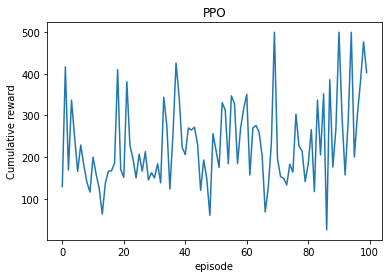

Average cumulative reward: 231.93
Is my agent good enough? True


In [24]:
# plot episode_rewards
plt.plot(ppo_agent.episode_rewards)
plt.title('PPO')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", np.mean(ppo_agent.episode_rewards))
print("Is my agent good enough?", np.mean(ppo_agent.episode_rewards) > 195)

### Task 3

In [25]:
ppo_agent.main(out_single=False, video_take=True, save_model=False, load_model=False, skip_train=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:05<?, ?it/s]


Bonus: load model

In [26]:
ppo_agent2 = PPO_Agent()
ppo_agent2.main(out_single=False, video_take=True, save_model=False, load_model=True, skip_train=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:01<?, ?it/s]


## Reference List

[1] S. Ogawa. "強化学習初心者向け】シンプルな実装例で学ぶQ学習、DQN、DDQN【CartPoleで棒立て：1ファイルで完結、Kearas使用】". [Source code]. Qiita. https://qiita.com/sugulu_Ogawa_ISID/items/bc7c70e6658f204f85f9. (accessed Mar. 7, 2023). \\
[2] MORIKATRON Inc. [Source code]. https://github.com/morikatron/PPO/tree/master/algo \\
[3] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, "Proximal Policy Optimization Algorithms", 2017. [Online]. Available: *arXiv:1707.06347*. \\
[4] Tensorflow. "Save and load models". [Source code]. https://www.tensorflow.org/tutorials/keras/save_and_load. (accessed Mar. 7, 2023).